# 2. Clean — UK Electricity Demand
**Worked on by:** Marin Janushaj  
**Goal:** Prepare the combined dataset (remove duplicates, fix datetimes, fill small gaps, resample hourly, etc.)

In [7]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

# Load combined file
df = pd.read_csv("../data/raw/uk_electricity_combined.csv")
print(df.shape)
df.head()

(417118, 22)


,SETTLEMENT_DATE,SETTLEMENT_PERIOD,ND,TSD,ENGLAND_WALES_DEMAND,EMBEDDED_WIND_GENERATION,EMBEDDED_WIND_CAPACITY,EMBEDDED_SOLAR_GENERATION,EMBEDDED_SOLAR_CAPACITY,NON_BM_STOR,...,IFA2_FLOW,BRITNED_FLOW,MOYLE_FLOW,EAST_WEST_FLOW,NEMO_FLOW,NSL_FLOW,ELECLINK_FLOW,VIKING_FLOW,GREENLINK_FLOW,SCOTTISH_TRANSFER
0,01-JAN-2022,1,21940,23275.0,20513,2713.0,6527.0,0.0,14008.0,0,...,-4.0,586.0,320.0,384.0,-100.0,210.0,0.0,0.0,0.0,NaN
1,01-JAN-2022,2,22427,23489.0,21021,2755.0,6527.0,0.0,14008.0,0,...,-4.0,583.0,320.0,403.0,-104.0,176.0,0.0,0.0,0.0,NaN
2,01-JAN-2022,3,21896,23672.0,20619,2930.0,6527.0,0.0,14008.0,0,...,-4.0,567.0,320.0,440.0,-4.0,-205.0,0.0,0.0,0.0,NaN
3,01-JAN-2022,4,20693,23272.0,19615,3090.0,6527.0,0.0,14008.0,0,...,-4.0,444.0,320.0,387.0,-6.0,-283.0,0.0,0.0,0.0,NaN
4,01-JAN-2022,5,19481,23958.0,18545,3161.0,6527.0,0.0,14008.0,0,...,-4.0,-383.0,320.0,476.0,-561.0,-686.0,0.0,0.0,0.0,NaN


In [8]:
# --- normalize column names ---
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]
print(df.columns.tolist())

# Detect likely datetime and demand columns
dt_col = next((c for c in df.columns if "time" in c or "date" in c), None)
val_col = next((c for c in df.columns if "demand" in c or "mw" in c or "value" in c), None)
print("Using:", dt_col, val_col)

['settlement_date', 'settlement_period', 'nd', 'tsd', 'england_wales_demand', 'embedded_wind_generation', 'embedded_wind_capacity', 'embedded_solar_generation', 'embedded_solar_capacity', 'non_bm_stor', 'pump_storage_pumping', 'ifa_flow', 'ifa2_flow', 'britned_flow', 'moyle_flow', 'east_west_flow', 'nemo_flow', 'nsl_flow', 'eleclink_flow', 'viking_flow', 'greenlink_flow', 'scottish_transfer']
Using: settlement_date england_wales_demand


In [9]:
# --- clean types ---
df[dt_col] = pd.to_datetime(df[dt_col], errors="coerce")
df[val_col] = pd.to_numeric(df[val_col], errors="coerce")

# Drop invalid rows
df = df.dropna(subset=[dt_col, val_col]).sort_values(dt_col)
df = df.drop_duplicates(subset=[dt_col])
df = df.rename(columns={dt_col: "timestamp", val_col: "demand_mw"})
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8690 entries, 259376 to 154158
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   timestamp                  8690 non-null   datetime64[ns]
 1   settlement_period          8690 non-null   int64         
 2   nd                         8690 non-null   int64         
 3   tsd                        7229 non-null   float64       
 4   demand_mw                  8690 non-null   int64         
 5   embedded_wind_generation   6499 non-null   float64       
 6   embedded_wind_capacity     6499 non-null   float64       
 7   embedded_solar_generation  5768 non-null   float64       
 8   embedded_solar_capacity    5768 non-null   float64       
 9   non_bm_stor                8690 non-null   int64         
 10  pump_storage_pumping       8690 non-null   int64         
 11  ifa_flow                   8690 non-null   int64         
 12  ifa2

/var/folders/cd/pyr3v6yx6hn7c56ncf7_24nh0000gn/T/ipykernel_5342/4142509216.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[dt_col] = pd.to_datetime(df[dt_col], errors="coerce")


2001-01-01 00:00:00 → 2025-10-16 00:00:00
count     8690.000000
mean     33905.402992
std       7643.952119
min          0.000000
25%      28283.250000
50%      34066.500000
75%      39080.750000
max      54430.000000
Name: demand_mw, dtype: float64


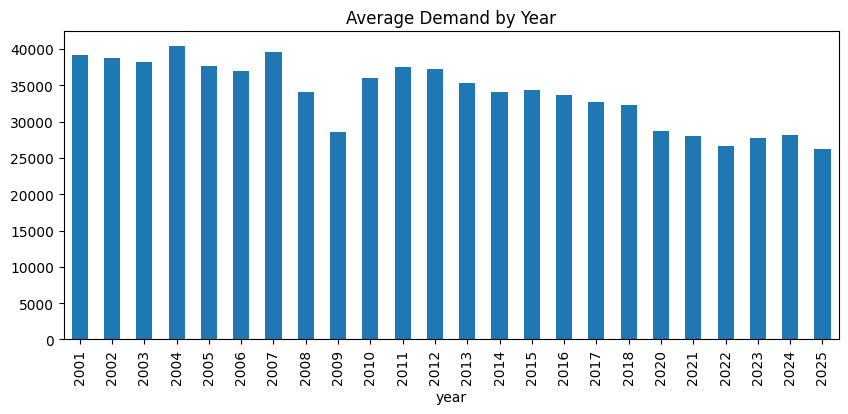

In [10]:
# --- check basic stats ---
print(df["timestamp"].min(), "→", df["timestamp"].max())
print(df["demand_mw"].describe())

df["year"] = df["timestamp"].dt.year
df.groupby("year")["demand_mw"].mean().plot(kind="bar", figsize=(10,4), title="Average Demand by Year")
plt.show()

In [11]:
# set datetime index
df = df.set_index("timestamp").sort_index()

# resample hourly and interpolate small gaps
hourly = df["demand_mw"].resample("1H").mean()
hourly = hourly.interpolate(limit=3)
hourly.head()

timestamp
2001-01-01 00:00:00    37761.000000
2001-01-01 01:00:00    38109.083333
2001-01-01 02:00:00    38457.166667
2001-01-01 03:00:00    38805.250000
2001-01-01 04:00:00             NaN
Freq: H, Name: demand_mw, dtype: float64

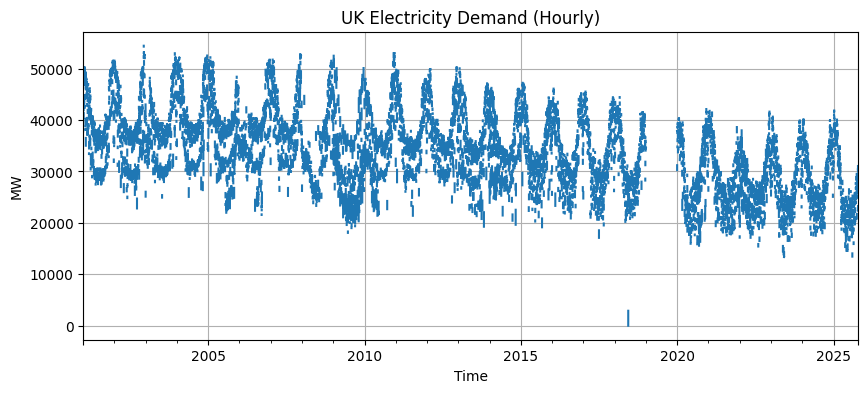

In [12]:
hourly.plot(figsize=(10,4), title="UK Electricity Demand (Hourly)")
plt.ylabel("MW"); plt.xlabel("Time"); plt.grid(True)
plt.show()

In [13]:
missing_ratio = hourly.isna().mean() * 100
print(f"Missing data: {missing_ratio:.2f}%")

# Drop negative or extreme spikes
hourly = hourly[(hourly > 1000) & (hourly < 100_000)]
print("Remaining records:", len(hourly))

Missing data: 84.00%
Remaining records: 34755


In [14]:
out_path = Path("../data/clean/uk_electricity_hourly.parquet")
out_path.parent.mkdir(parents=True, exist_ok=True)
hourly.to_frame(name="demand_mw").to_parquet(out_path)
print("✅ Saved:", out_path)

✅ Saved: ../data/clean/uk_electricity_hourly.parquet
